## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [59]:
!pip install nlp

In [60]:
# Refer https://huggingface.co/datasets/dair-ai/emotion
!pip install datasets

In [61]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
from datasets import load_dataset


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.1


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [62]:
# Import the emotions dataset
ds = load_dataset("dair-ai/emotion", "split")

In [63]:
# Let's look at the dataset
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

We can see that the dataset has 20000 rows which is split in to three parts - train(16000 rows), validation(2000 rows) and test (2000 rows).
There are two features - namely the text of the tweet and the label/emotion of the tweet. For ease of use, let's extract each of these into separate dataset variables.

In [64]:
train = ds['train']
val = ds['validation']
test = ds['test']

In [65]:
# Let's now try to extract the text of tweets and their emotion / class label in to two lists
extract = lambda d: ([x['text'] for x in d], [x['label'] for x in d])

In [66]:
(tweets, labels) = extract(train)

In [67]:
tweets[5], labels[5]

('ive been feeling a little burdened lately wasnt sure why that was', 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [68]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [69]:
# Create a tokenizer object that only considers the 10000 frequent words. All other words are considered out of vocabulary (oov) and marked with a special token <UNK> that we define below
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)


In [70]:
# To show the working
print(tweets[0])
tokenizer.texts_to_sequences([tweets[0]])

i didnt feel humiliated


[[2, 139, 3, 679]]

In [71]:
#https://www.tensorflow.org/tutorials/load_data/text

from tensorflow.keras.layers import TextVectorization

VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

binary_vectorize_layer.adapt(tweets)

binary_vectorize_layer(tweets[0]).numpy()


array([0, 1, 1, ..., 0, 0, 0])

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

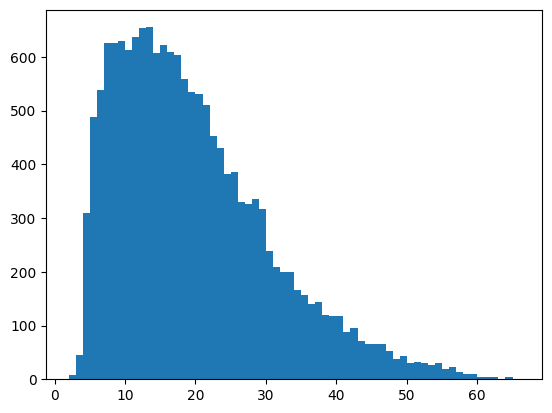

In [72]:
# As tweets are of varying lengths, we have to fix them to a fixed size/length. It may cause padding or truncation to adhere to the length. Let's look at lengths of the tweets

lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [73]:
maxlen = 50
# We are choosing this as the cut off length. Tweets less than this will be padded with 0s. Tweets greater than this will be truncated.
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [74]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [75]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [76]:
padded_train_seq[0:5]

array([[   2,  139,    3,  679,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
          32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  17, 3060,    7, 1149,    5,  286,    2,    3,  495,  438,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   

In [77]:
MAX_SEQUENCE_LENGTH = maxlen

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

int_vectorize_layer.adapt(tweets)
int_vectorize_layer(tweets[0:5]).numpy()

array([[   2,  140,    3,  686,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   2,   40,  102,   60,    9,   15,  500,    5,   15, 4011,  561,
          32,   60,   61,  128,  148,   76, 1529,    4,   22, 1289,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  17, 3316,    7, 1160,    5,  289,    2,    3,  501,  438,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   

In [78]:
int_vectorize_layer.get_vocabulary()[686]

'humiliated'

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [79]:
classes = set(labels)
classes
# Equivalent to anger(3), joy(1), love(2), surprise(5), fear(4), sadness(0)

{0, 1, 2, 3, 4, 5}

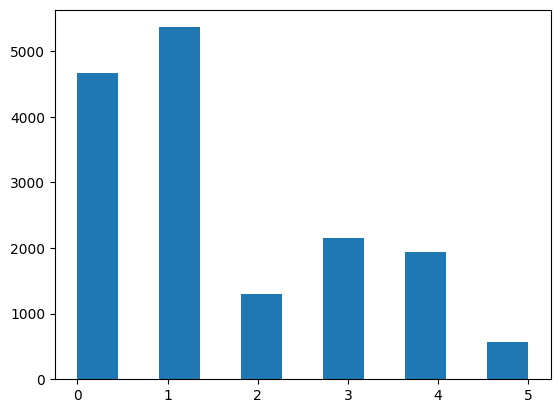

In [80]:
plt.hist(labels, bins=11)
plt.show()

In [81]:
# Classes are imbalanced.
# In original dataset the labels were textual. So the following code was there to get the class-to-index and index-to-class mappings

#class_to_index = dict((c,i) for i,c in enumerate(classes))
#index_to_class = dict((v,k) for k,v in class_to_index.items())

In [82]:
#class_to_index

In [83]:
#index_to_class

In [84]:
#names_to_ids = lambda labels : np.array([class_to_index.get(x) for x in labels])

In [97]:
#train_labels = names_to_ids(labels)
train_labels = np.array(labels)

In [86]:
#train_labels[0], labels[0]

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM, Input

model = Sequential([
        Input((maxlen,)),
        Embedding(10000, 16),
        Bidirectional(LSTM(20, return_sequences = True)),
        Bidirectional(LSTM(20)),
        Dense(6,activation='softmax')
])
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [100]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 50, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 50, 40)              │           5,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 40)                  │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │             246 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [101]:
# Extract the tweets and labels of the validation set
(val_tweets, val_labels) = extract(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = np.array(val_labels)
val_seq[0]

array([ 17,   8, 157, 260,   4, 343,  16,  51,  19, 212,   1,  50,  10,
        13, 533,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [105]:
int_vectorize_layer(val_tweets)

<tf.Tensor: shape=(2000, 50), dtype=int64, numpy=
array([[ 17,   9, 156, ...,   0,   0,   0],
       [  2,   3,  14, ...,   0,   0,   0],
       [  2,   3,  14, ...,   0,   0,   0],
       ...,
       [  2,   3,  79, ...,   0,   0,   0],
       [  2, 393,   3, ...,   0,   0,   0],
       [  2,   3,  14, ...,   0,   0,   0]])>

In [104]:
val_tweets[0], val_seq[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 array([ 17,   8, 157, 260,   4, 343,  16,  51,  19, 212,   1,  50,  10,
         13, 533,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
 0)

In [108]:
h = model.fit(padded_train_seq, train_labels,
              epochs=20,
              validation_data = (val_seq, val_labels),
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3534 - loss: 1.5641 - val_accuracy: 0.5635 - val_loss: 1.1143
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6561 - loss: 0.8885 - val_accuracy: 0.6880 - val_loss: 0.8153
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7875 - loss: 0.5827 - val_accuracy: 0.7945 - val_loss: 0.5946
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8677 - loss: 0.4029 - val_accuracy: 0.8325 - val_loss: 0.5126
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9045 - loss: 0.2935 - val_accuracy: 0.8415 - val_loss: 0.5056
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9284 - loss: 0.2341 - val_accuracy: 0.8480 - val_loss: 0.4923
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9474 - loss: 0.1735 - val_accuracy: 0.8530 - val_loss: 0.4788
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9607 - loss: 0.1339 - val_a

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

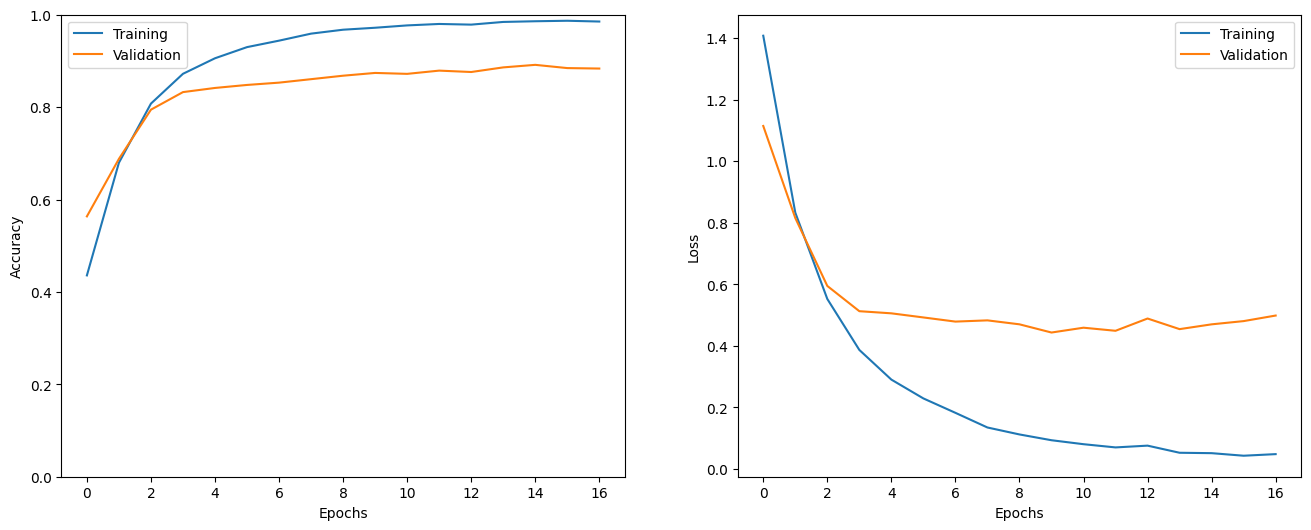

In [109]:
show_history(h)

In [111]:
(test_tweets, test_labels) = extract(test)
test_seq = get_sequences(tokenizer,test_tweets)
test_labels = np.array(test_labels)

In [112]:
_ = model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8705 - loss: 0.5245


In [115]:
# Check prediction for a random tweet
i = random.randint(0, len(test_labels)-1)

print('Tweet: ', test_tweets[i])
print('Emotion: ', test_labels[i])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion: ', pred_class)

Tweet:  i have to admit that i feel the teensiest bit envious of my friends who live there
Emotion:  3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Emotion:  3


In [121]:
preds = model.predict(test_seq)
pred_classes = np.argmax(preds,axis=1)
pred_classes

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([0, 0, 0, ..., 1, 1, 4])

In [117]:
preds

array([[9.9823606e-01, 4.0151735e-04, 1.5820344e-05, 1.3380741e-03,
        8.1469561e-06, 4.7255827e-07],
       [9.9819809e-01, 3.1804241e-04, 2.0044999e-05, 1.4522836e-03,
        1.0885792e-05, 6.1199336e-07],
       [9.9819618e-01, 5.8857998e-04, 1.7460417e-05, 1.1688685e-03,
        2.5901694e-05, 3.0176848e-06],
       ...,
       [9.7440767e-05, 9.9961591e-01, 1.8339709e-04, 9.6959579e-05,
        2.3168623e-06, 3.8586927e-06],
       [7.1913557e-05, 9.9976057e-01, 8.7031258e-05, 7.6893710e-05,
        1.5448056e-06, 2.1106534e-06],
       [8.9080096e-04, 1.5906554e-02, 4.9933889e-03, 1.5265561e-03,
        5.8636028e-01, 3.9032236e-01]], dtype=float32)

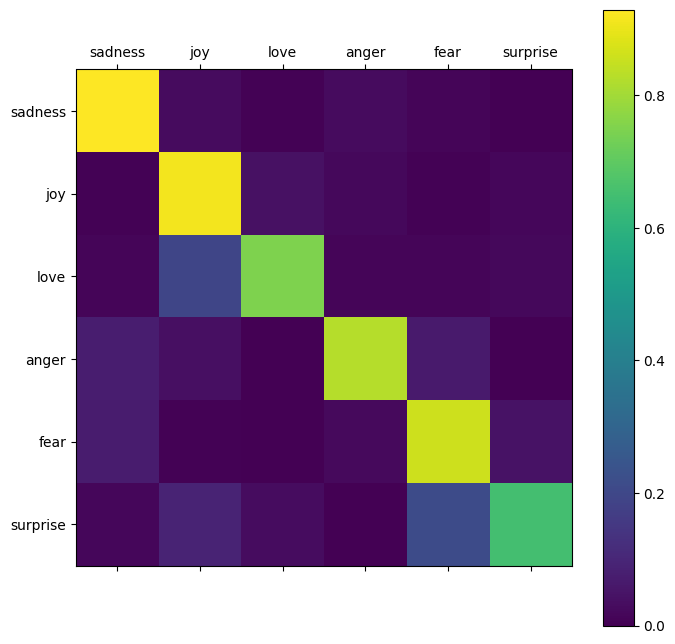

In [123]:
# Equivalent to anger(3), joy(1), love(2), surprise(5), fear(4), sadness(0)
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
#show_confusion_matrix(test_labels, pred_classes, list(classes))
show_confusion_matrix(test_labels, pred_classes, class_names)